<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">3. Image processing - Round 2</p>

### En esta práctica, pondremos en práctica conceptos aprendidos durante la clase teórica. Empezaremos por detectar corners en una imagen a partir del método Harris

### Tal como hemos estudiado, Harris propone detecta esquinas en imágenes a partir del análisis de la distribución de sus derivadas en X y en Y. 

### La matriz de Harris, R, se calcula a partir de:

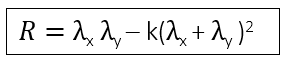

### Si sustituimos el valor de lambda-x y lambda-y por el valor de la imagen de entrada convolucionada con un filtro derivativo en X y en Y vemos que llegamos a una expresión similar

### El método Harris propone un  método basado en el análisis de diferencia de intensidades para detectar esquinas. Tal como explica la documentación de opencv sobre el método (https://docs.opencv.org/3.4/dc/d0d/tutorial_py_features_harris.html), la expresión anterior es análoga a
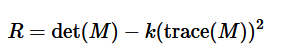

### donde M es
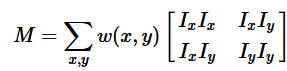

### Es decir, si movemos un "sliding window" por la imagen de entrada y calculamos el valor de M, podemos aplicar la fórmula de Harris para detectar esquinas

### Apliquemos de manera manual el método Harris a la detección de esquinas de la imagen 0. Primero, convierte tu imagen a escala de grises y aplica un filtro Sobel en X y en Y. Para ello, deberás primero filtrar el ruido con un filtro gaussiano. Usa las funciones de opencv para esto: cv2.GaussianBlur y cv2. Sobel


In [23]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

### Calcula el valor de IxIx, IyIy e Ixy de la fórmula de Harris. Después, calcula el valor de la matriz R para cada window

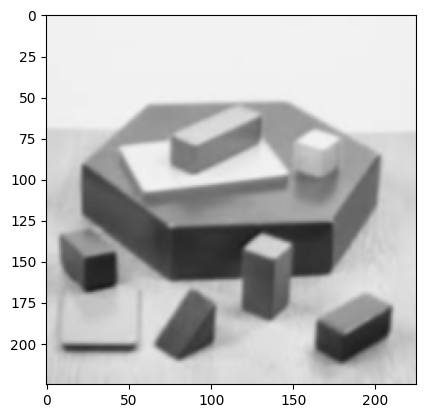

(225, 225, 3)
Finding Corners...


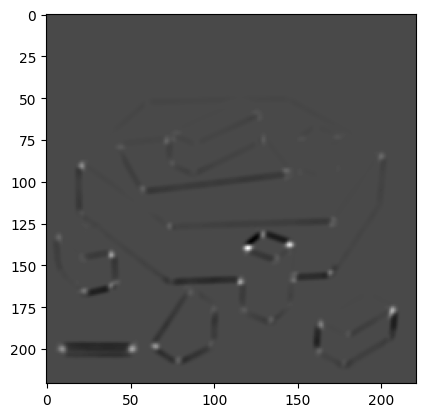

In [24]:
# Implementa aquí tu código

# Read image
img = cv2.imread('images/0.jpg')
window_size = 5  # 5 seems to be a good value
offset = int( window_size / 2 )
ddepth = cv2.CV_64F  # We will get maximum precision for the result

# Turn to gray scale, but before we need to blur the image to filter noise
img = cv2.GaussianBlur(img, (5, 5), 0)
plt.imshow(img)
plt.show() 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(img.shape)
width, height, channels = img.shape

# Gradients for x and y
dx = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=5)
dy = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=5)

# Compute Ix2, Iy2 and Ixy
dx2 = dx * dx
dy2 = dy * dy
dxy = dx * dy

# Initialise matrix R
matrix_R = np.zeros((width - offset * 2, height - offset * 2))  # We don't want to consider the borders
k = 0.04  # Value recommended by Rodrigo

print ("Finding Corners...")
for y in range(offset, height-offset):
    for x in range(offset, width-offset):
        Sx2 = np.sum(dx2[y-offset:y+1+offset, x-offset:x+1+offset])
        Sy2 = np.sum(dy2[y-offset:y+1+offset, x-offset:x+1+offset])
        Sxy = np.sum(dxy[y-offset:y+1+offset, x-offset:x+1+offset])

#   H(x,y)=[[Sx2,Sxy],[Sxy,Sy2]]
        H = np.array([[Sx2,Sxy],[Sxy,Sy2]])

        R = np.linalg.det(H) - 0.04 * (np.trace(H) ** 2)
#   R=det(H)-k(Trace(H))^2 )
        # Implementa aquí tu código para calcular R
        matrix_R[y-offset, x-offset]=R

plt.imshow(matrix_R, cmap='gray')

### A continuación se normaliza el valor de R. Muestra los vértices calculados sobre la imagen de entrada

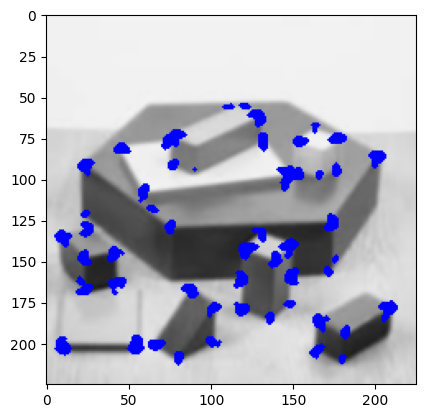

In [25]:

# We create another variable to avoid modifying the original image
threshold = 0.29  # 0.3 didnt detect all corners, 0.29 is the best value (0.28 gave almost all the image as corners)
our_Harris = np.copy(img)

# Normalise matrix R
cv2.normalize(matrix_R, matrix_R, 0, 1, cv2.NORM_MINMAX)
plt.imshow(matrix_R, cmap='gray')

# Find corners
for y in range(offset, height-offset):
    for x in range(offset, width-offset):
        if matrix_R[y-offset, x-offset] > threshold:
            cv2.circle(our_Harris, (x, y), 1, (0, 0, 255), -1)  # Draw a red circle in the center of the corner

# Implementa aquí tu código para visualizar los resultados
plt.imshow(our_Harris, cmap='gray')

### Compara el resultado obtenido con el que consigues al aplicar la función cv2.cornerHarris a la imagen de entrada. Juega con sus parámetros apra que el resultado sea el más preciso

As we can see, opencv detects more corners than our implementation. Additionally, these corners are much more precise than ours.


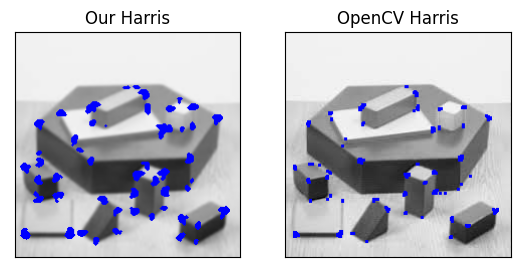

In [26]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Apply Harris corner detector to the image
cv2_Harris = cv2.imread('images/0.jpg')

# Convert to gray scale
gray = np.float32(cv2.cvtColor(cv2_Harris, cv2.COLOR_BGR2GRAY))

# Detect corners. The parameters used are the same as in the previous part
block_size = 5
ksize = 5
k = 0.04
corners = cv2.cornerHarris(gray, 2, 3, 0.04)

# Dilate to mark the corners (used from the OpenCV documentation) (not important)
corners = cv2.dilate(corners, None)

# We wont use the same threshold
threshold = 0.01
cv2_Harris[corners>threshold*corners.max()]=[0,0,255]

# We'll plot both results in the same figure
plt.subplot(121),plt.imshow(our_Harris, cmap='gray')
plt.title('Our Harris'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(cv2_Harris, cmap='gray')
plt.title('OpenCV Harris'), plt.xticks([]), plt.yticks([])

print("As we can see, opencv detects more corners than our implementation. Additionally, these corners are much more precise than ours.")

### Aplicación del método Hough. Usa la función HoughLinesP de opencv para convertir tus edges en boundaries. Aplica el filtro de canny a la imagen original (ver opencv-canny) y después aplica Hough para conseguir ver las lineas en la imagen "hough-ex.jpg"

### Primero, lee la imagen y conviértela a RGB

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

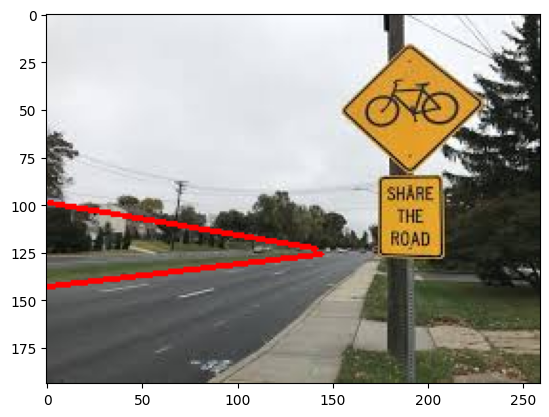

In [51]:
# Read image
img = cv2.imread('images/hough-ex.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

# Convert to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Canny filter
edges = cv2.Canny(gray, 50, 150, apertureSize=3)

# Apply Hough transform
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)

# Draw lines
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(img, (x1,y1), (x2,y2), (255,0,0), 2)

plt.imshow(img)

### A continuación, aplica un filtro canny para detectar bordes usando la función cv2.Canny. 

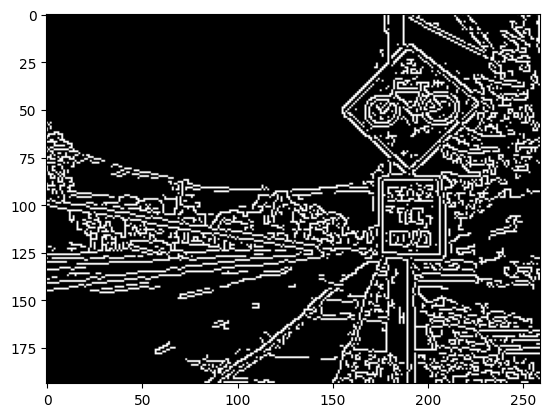

In [5]:

low_threshold = 50
high_threshold = 100

# Apply Canny edge detector
edges = cv2.Canny(img, low_threshold, high_threshold)

# Plot the result
plt.imshow(edges, cmap='gray')

### utiliza la función cv2.HoughLinesP para encontrar los boundaries de tus bordes (lineas rectas). Juega con los parámetros 
### propuestos en el ejercicio para encontrar el mayor número de lineas rectas en la imagen que correspondan con la realidad

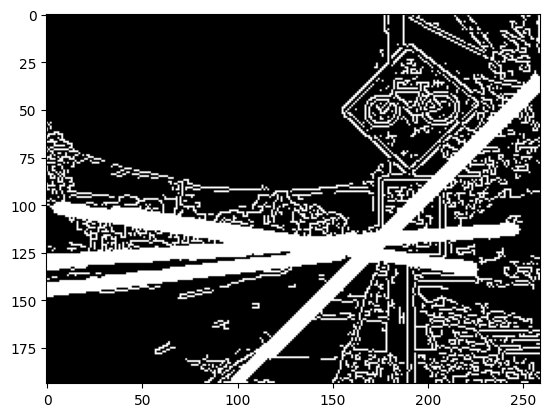

In [50]:
rho = 1
theta = np.pi/180
threshold = 100
min_line_length = 100
max_line_gap = 10
line_image = np.copy(edges)
 #creating an image copy to draw lines on# Run Hough on the edge-detected image

# We call the OpenCV function to find lines in the image
lines = cv2.HoughLinesP(line_image, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

# Paint the lines on the image
for line in lines:
    for x1,y1,x2,y2 in line:  # We get the extreme points of the line
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)

# Plot the result
plt.imshow(line_image, cmap='gray')

### SIFT DETECTOR

### en la siguiente parte de la práctica calcularemos blobs relevante para la imagen "hough.ex.jpg". Primero usaremos la función "blob_log" y "blob_dog" del paquete skimage para detectar blobs en la imagen de entrada por "difference of gaussians" y por "laplacian of gaussian".

### aplica las funcionas blob_log y blob_dog y muestra los blobs encontrados en cada caso demostrando que son similares. ¿Qué diferencia había entre la "laplacian of gaussian" y la "difference of gaussian"? ¿Se pueden usar de manera indistinta para encontrar blobs? Razona tu respuesta en el informe

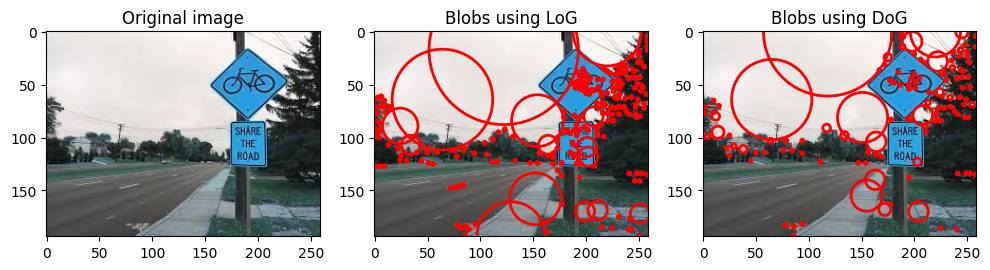

In [31]:
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

import matplotlib.pyplot as plt

image=cv2.imread('images/hough-ex.jpg')
#image = data.hubble_deep_field()[0:500, 0:500]
image_gray = rgb2gray(image)

blobs_log = blob_log(image_gray, threshold=0.1)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, threshold=0.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)


# Implementa aquí tu código para visualizar los blobs calculados usando LoG y DoG
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original image')

for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax[1].add_patch(c)
ax[1].imshow(image, cmap='gray')
ax[1].set_title('Blobs using LoG')

for blob in blobs_dog:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax[2].add_patch(c)
ax[2].imshow(image, cmap='gray')
ax[2].set_title('Blobs using DoG')

plt.show()



### En este último ejercicio, aplicaremos el método SIFT para encontrar important points y sus descriptores en dos imágenes consecutivas para hacer su stitching. Deberás instalar el paquete pandas

In [32]:
# pip install pandas

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Lee las imágenes car0 y car1 y almacénalas en la variable "left" y "right". Tras leerlas, deberás aplicar un resize a la dimensión 1024,768 aplicando la flag cv2.INTER_AREA

In [40]:
left = cv2.imread('images/car0.jpg')
right = cv2.imread('images/car1.jpg')

dim=(1024,768)
# Resize the images
left = cv2.resize(left, dim, interpolation = cv2.INTER_AREA)
right = cv2.resize(right, dim, interpolation = cv2.INTER_AREA)

### Aplica la función sift.detectAndCompute de python aplicada sobre la imagen car0 y car1 de nuestro dataset para encontrar los keypoints en ellas según el método SIFT


### Una vez encontrados los keypoints y los descriptores tendremos que hacer el "matching" entre ellos. Para ellos aplicaremos la comparativa de distancias entre candidatos a "matched features" propuesto por R.Lowe.

### Este método dice que, por cada keypoint de la imagen 1 tendré candidatos a "best match" (mismo keypoint en imagen 2) en la siguiente imagen. En este ejercicio, guardamos en la variable "matches" listas del análisis entre descriptores de ambas imágenes
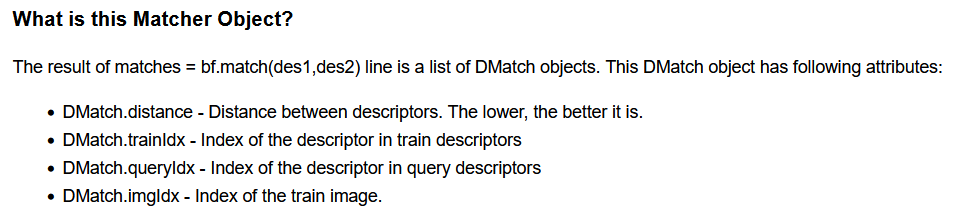

### Revisa la documentación aquí: https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html

### Implementa el "ratio test" de Lowe para quedarte con los mejores matches o coincidencias entre keypoints. Este test dice: si la distancia entre el keypoint A de la imagen 1 y su mejor candidato a keypoint correspondiente en la imagen 2 es MENOR que el 75% de la distancia entre A y el segundo mejor candidato, entonces el keypoint A y su mejor candidato es una pareja de matches

In [34]:
def stitching(img1, img2, min_match_count = 10):
    sift = cv2.SIFT_create()
    
    # Obtain keypoints and descriptors using SIFT
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)
    

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    
   
    good_matches = []
            
    # Lowe's ratio test
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    if len(good_matches) > min_match_count:
        src_pts = np.float32([ keypoints1[good_match.queryIdx].pt
                              for good_match in good_matches ]).reshape(-1,1,2)
        
        dst_pts = np.float32([ keypoints2[good_match.trainIdx].pt 
                              for good_match in good_matches ]).reshape(-1,1,2)
        
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        result = warpImages(img2, img1, M)
        return result
    
    else:
        print ("We don't have enough number of matches between the two images.")
        print ("Found only " + str(len(good_matches)) + " matches.")
        print ("We need at least " + str(min_match_count) + " matches.")
        


### las siguientes funciones son de ayuda. No hay que implementarlas

In [35]:
def showplt(image, title=None, pltnative=False):
    if pltnative: 
        plt.imshow(image)
    else: 
        plt.imshow(image[...,::-1])
    plt.title(title)
    plt.xticks([]), plt.yticks([]) 
    plt.show()
    
def warpImages(img1, img2, H):
    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]
    
    list_of_points_1 = np.float32([
        [0,0], 
        [0,rows1],
        [cols1,rows1], 
        [cols1,0]
    ])
    list_of_points_1 = list_of_points_1.reshape(-1,1,2)

    temp_points = np.float32([
        [0,0], 
        [0,rows2], 
        [cols2,rows2],
        [cols2,0]
    ])
    temp_points = temp_points.reshape(-1,1,2)
    
    list_of_points_2 = cv2.perspectiveTransform(temp_points, H)
    
    list_of_points = np.concatenate((list_of_points_1, list_of_points_2), axis=0)
    
    ##Define boundaries:
    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
    
    translation_dist = [-x_min,-y_min]
    
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0,0,1]])
    
    output_img = cv2.warpPerspective(img2, 
                                     H_translation.dot(H), 
                                     (x_max - x_min, y_max - y_min))
    ## Paste the image:
    output_img[translation_dist[1]:rows1+translation_dist[1], 
               translation_dist[0]:cols1+translation_dist[0]] = img1
    
    return output_img
#

### Llama a la función "warp" para hacer el stitching. Rota la imagen de salida para que se vea recta

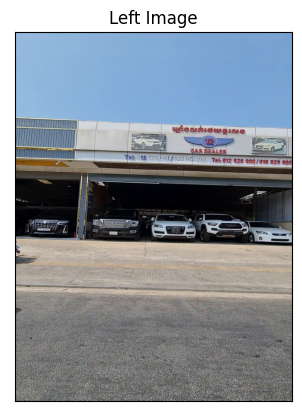

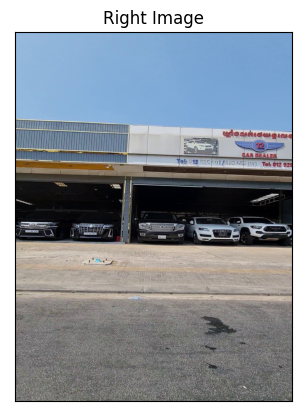

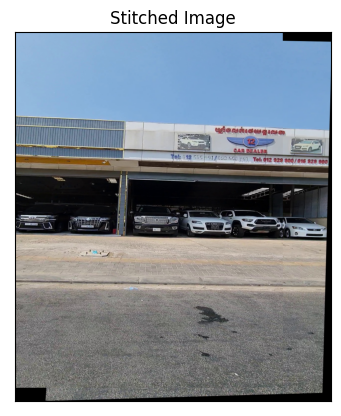

In [45]:

image = stitching(left, right)

# Rotate all images
left = cv2.rotate(left, cv2.ROTATE_90_CLOCKWISE)
right = cv2.rotate(right, cv2.ROTATE_90_CLOCKWISE)
image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

showplt(left, title='Left Image')
showplt(right, title='Right Image')
showplt(image, title='Stitched Image')
